In [1]:
from os.path import join, basename, abspath

from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt import open_raster
import numpy as np
import yaml

In [2]:
root=r'../models/sfincs'

data_libs=[
    r'../data/sfincs_data/data_catalog.yml', 
    r'../data/sfincs_data/gtsm.yml',
    r'../models/wflow/wflow.yml' # link to wflow output data 
]

In [3]:
# configuration file
sf_config = configread('sfincs_update_forcing.yml')
print(yaml.dump(sf_config, sort_keys=False))

setup_config:
  tref: 20190312 000000
  tstart: 20190312 000000
  tstop: 20190322 000000
  dtout: 86400
setup_discharge_forcing:
  timeseries: wflow_run_era5
setup_waterlevel_forcing:
  geodataset: gtsm_idai_era5_spw
  buffer: 5000
write_forcing: null
write_config: null



In [4]:
runs = ['run_chirps', 'run_era5', 'run_chirps_vito', 'run_era5_vito']

for run in runs:
    sf_config['setup_discharge_forcing'].update({'timeseries': f'wflow_{run}'})
    # sf_config['setup_config'].update({'tstop': '20190314 000000'}) # short test run
    # read base model
    sf = SfincsModel(root=root, mode='r', logger=setuplog('sfincs'), data_libs=data_libs)
    sf.read()
    # create subfolder for run
    sf.set_root(join(root, run), mode='w+')
    # update paths to static files in base root
    static_maps = ['mskfile', 'indexfile', 'depfile', 'sbgfile']
    sf.config.update({k: f'../{basename(sf.config[k])}' for k in static_maps})
    # update forcing
    sf.update(opt=sf_config)

2023-04-23 21:38:57,029 - sfincs - log - INFO - HydroMT version: 0.7.2.dev0
2023-04-23 21:38:57,080 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/data_catalog.yml
2023-04-23 21:38:57,114 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/gtsm.yml
2023-04-23 21:38:57,118 - sfincs - data_catalog - INFO - Parsing data catalog from ../models/wflow/wflow.yml
2023-04-23 21:38:57,128 - sfincs - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.0.dev0).
2023-04-23 21:38:57,165 - sfincs - sfincs - WARNING - depfile not found at c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\sfincs\sfincs.dep
2023-04-23 21:38:58,257 - sfincs - sfincs - INFO - Model read
2023-04-23 21:38:58,260 - sfincs - model_api - INFO - setup_discharge_forcing.geodataset: None
2023-04-23 21:38:58,261 - sfincs - model_api - INFO - setup_discharge_forcing.timeseries: wflow_run_chirps
2023-04-23 21:38:58,262 - sfincs - model_api - INFO 

In [5]:
# this step can be skipped if you don't have the SFINCS executable
# the output is already in the repo
# this should take approx ~5 min per simulation

# uncomment to run the model
from execute import execute
exe = abspath(r'../bin/sfincs/sfincs.exe')

for run in runs:
    print(run)
    log = []
    for line in execute([exe], cwd=join(root, run), shell=True):
        # print(line, end='')
        log.append(line)
    with open(join(root, run, 'sfincs.log'), 'w') as f:
        f.writelines(log)

run_chirps
run_era5
run_chirps_vito
run_era5_vito


In [6]:
from hydromt_sfincs import utils

# first we are going to select our highest-resolution elevation dataset
depsbg_fn = join(root, "subgrid", "dep_subgrid.tif")
da_dep = open_raster(depsbg_fn).load()
hmin = 0.05  # minimum flood depth [m] to plot

hmax_out = {}
for run in runs:
    sf = SfincsModel(join(root, run), mode="r")

    # zsmax is computed by SFINCS as the maximum water level in the domain
    da_zsmax = sf.results["zsmax"].load()

    # downscale the floodmap 
    da_hmax = utils.downscale_floodmap(
        zsmax=da_zsmax, 
        dep=da_dep, 
        hmin=hmin, 
        # gdf_mask=gdf_osm, 
        # floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
    )

    # update attributes for colorbar label later
    da_hmax.attrs.update(long_name="flood depth", unit="m")

    # 
    hmax_out[run] = da_hmax

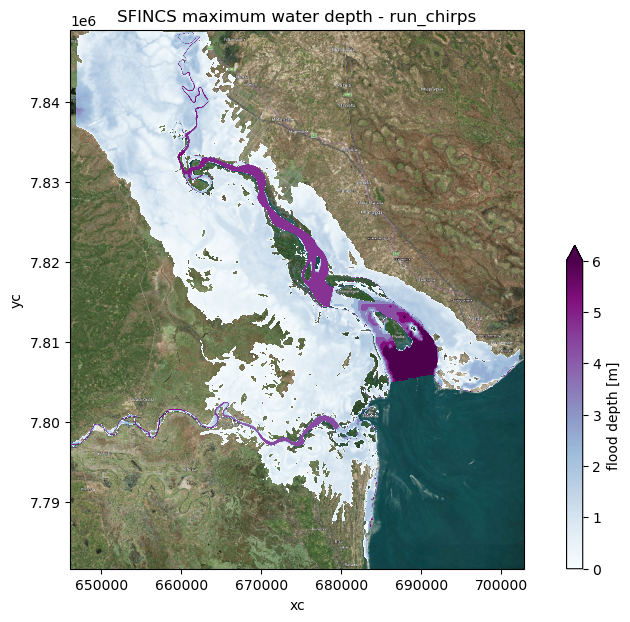

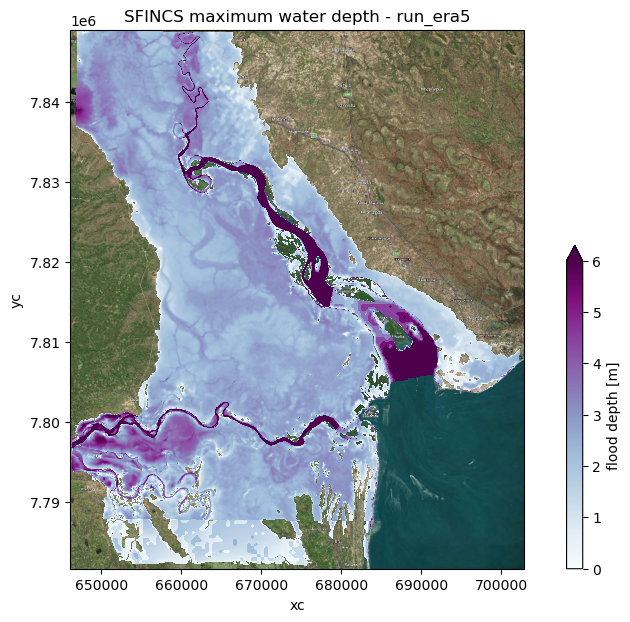

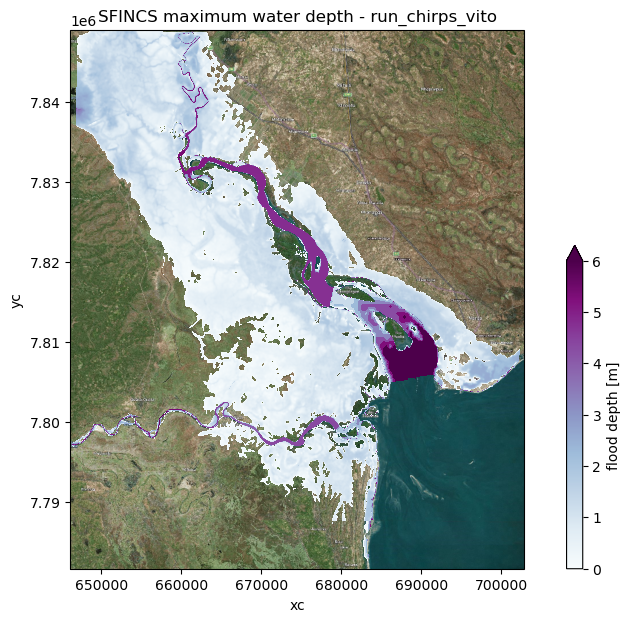

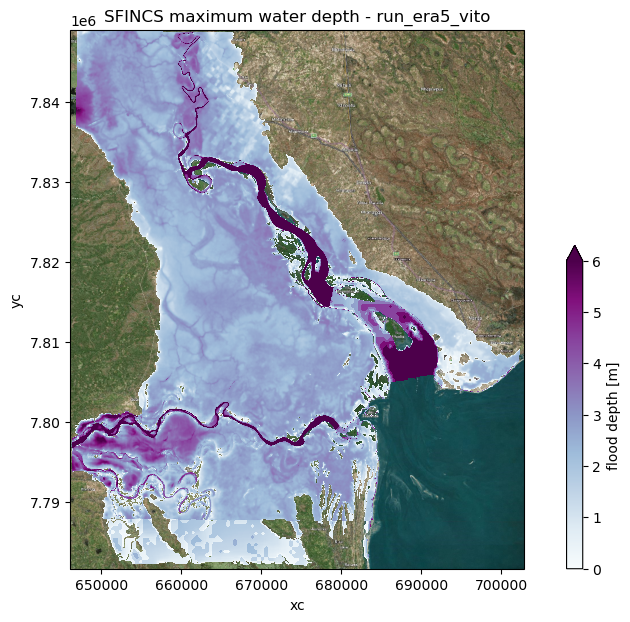

In [8]:
# Lastly, we create a basemap plot with hmax on top
for run, da_hmax in hmax_out.items():
    fig, ax = sf.plot_basemap(
        fn_out=None,
        variable="", # no variable to plot, only basemap
        plot_bounds=False, 
        plot_geoms=False,
        bmap="sat",
        zoomlevel=12,
        figsize=(11, 7),
    )

    cax_fld = da_hmax.plot(
        x="xc", y="yc",
        ax=ax,
        vmin=0, vmax=6,
        cmap="BuPu",
        cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
    )

    _ = ax.set_title(f"SFINCS maximum water depth - {run}")
    fig.savefig(join(root, run, f"{run}_hmax.png"), dpi=300, bbox_inches="tight")
